# Comparing results from SIMONA calculation against results of PowerFactory calculation
Positive values in difference indicate higher values within SIMONA.

In [7]:
# ===== Read in both results =====
import json
import os
from collections import defaultdict
from csv import DictWriter
from datetime import datetime
from math import sqrt

import numpy as np
from matplotlib import pyplot as plt
from numpy import mean

from tcv.calculation.result import GridResultThreeWinding
from tcv.encoder import CustomDecoder
from tcv.encoder.DictEncoder import DictEncoder
from tcv.util import CsvFileWriter

result_directory = os.path.join("..", "..", "..", "results", "three_winding")
simona_result_file = os.path.join(result_directory, "simona_withMainFieldLosses.json")
dpf_result_file = os.path.join(result_directory, "dpf_withMainFieldLosses.json")
diff_result_file = os.path.join(result_directory, "simona_vs_powerfactory.json")
diff_csv_file = os.path.join("..", "..", "..", "csv", "three_winding", "%s_simona_vs_dpf_diff.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")
rmse_csv_file = os.path.join("..", "..", "..", "csv", "three_winding", "%s_simona_vs_dpf_rmse.csv") % datetime.strftime(
    datetime.now(), "%Y%m%d")

# --- SIMONA results ---
if os.path.exists(simona_result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated SIMONA results are available. Load them.")
    with open(simona_result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        simona_results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    raise IOError("Unable to gather results of SIMONA.")

# --- PowerFactory results ---
if os.path.exists(dpf_result_file):
    # The result file exists. Read it and use it
    print("Pre-calculated PowerFactory results are available. Load them.")
    with open(dpf_result_file, "r") as file_to_read:
        json_string = file_to_read.read()
        dpf_results = json.loads(json_string, object_hook=CustomDecoder.custom_decode)
else:
    raise IOError("Unable to gather results of PowerFactory.")

# ===== Bring together both results =====
if not len(simona_results) == len(dpf_results):
    raise IOError("Uneven amount of results")

diff = []
for simona_result, dpf_result in zip(simona_results, dpf_results):
    # Some consistency checking
    if not simona_result['tap_pos'] == dpf_result['tap_pos']:
        raise ValueError("Mismatch in results. Matched different tap positions")
    if abs(simona_result['p_mv'] - dpf_result['p_mv']) > 0.1:
        raise ValueError(
            "Mismatch in results. Matched different medium voltage powers. tap_pos: %i, Simona: %.3f / %.3f MW, PowerFactory: %.3f / %.3f MW" % (
                simona_result['tap_pos'], simona_result['p_mv'], simona_result['p_lv'], dpf_result['p_mv'],
                dpf_result['p_lv']))
    if abs(simona_result['p_lv'] - dpf_result['p_lv']) > 0.1:
        raise ValueError(
            "Mismatch in results. Matched different low voltage powers. tap_pos: %i, Simona: %.3f / %.3f MW, PowerFactory: %.3f / %.3f MW" % (
                simona_result['tap_pos'], simona_result['p_mv'], simona_result['p_lv'], dpf_result['p_mv'],
                dpf_result['p_lv']))

    diff.append({
        'tap_pos': simona_result['tap_pos'],
        'p_mv': simona_result['p_mv'],
        'p_lv': simona_result['p_lv'],
        'result': GridResultThreeWinding.subtract(simona_result['result'], dpf_result['result'])
    })

# ===== Write results, if not yet done =====
if not os.path.exists(diff_result_file):
    with open(diff_result_file, "w") as file_to_write_to:
        print("Writing diff to file")
        json.dump(diff, file_to_write_to, cls=DictEncoder, indent=2)

if not os.path.exists(diff_csv_file):
    CsvFileWriter.write_for_pgf_surf_plot(p_mv_tick_num=21, p_mv_rated_mw=300.0, p_lv_tick_num=21, p_lv_rated_mw=100.0,
                                          tap_range=range(-10, 11), result_json_path=diff_result_file,
                                          csv_file_path=diff_csv_file, col_sep=",")

# ===== Group results by tap position =====
tap_to_result = defaultdict(list)
for d in diff:
    tap_to_result[d['tap_pos']].append(d)

# ===== Calculate measures per tap =====
tap_to_error = []
for tap, results in tap_to_result.items():
    v_mv_pu = list(map(lambda r: r['result'].v_mv_pu, results))
    v_lv_pu = list(map(lambda r: r['result'].v_lv_pu, results))
    v_ang_mv_degree = list(map(lambda r: r['result'].v_ang_mv_degree, results))
    v_ang_lv_degree = list(map(lambda r: r['result'].v_ang_lv_degree, results))

    delta_v_mv_max = max(v_mv_pu)
    delta_v_mv_min = min(v_mv_pu)
    delta_v_mv_avg = mean(v_mv_pu)
    delta_v_mv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_mv_pu)) / len(v_mv_pu))
    delta_v_lv_max = max(v_lv_pu)
    delta_v_lv_min = min(v_lv_pu)
    delta_v_lv_avg = mean(v_lv_pu)
    delta_v_lv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_lv_pu)) / len(v_lv_pu))

    delta_v_ang_mv_max = max(v_ang_mv_degree)
    delta_v_ang_mv_min = min(v_ang_mv_degree)
    delta_v_ang_mv_avg = mean(v_ang_mv_degree)
    delta_v_ang_mv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_ang_mv_degree)) / len(v_ang_mv_degree))
    delta_v_ang_lv_max = max(v_ang_lv_degree)
    delta_v_ang_lv_min = min(v_ang_lv_degree)
    delta_v_ang_lv_avg = mean(v_ang_lv_degree)
    delta_v_ang_lv_rmse = sqrt(sum(map(lambda v: pow(v, 2), v_ang_lv_degree)) / len(v_ang_lv_degree))

    print(
        "Tap position: %i\n\tdelta_v\n\t\tmax\t= %.3e\t%.3e\n\t\tmin\t= %.3e\t%.3e\n\t\tavg\t= %.3e\t%.3e"
        "\n\t\trmse\t= %.3e\t%.3e\n\tdelta_v_ang\n\t\tmax\t= %.3e\t%.3e\n\t\tmin\t= %.3e\t%.3e\n\t\tavg\t= %.3e\t%.3e"
        "\n\t\trmse\t= %.3e\t%.3e" % (
            tap, delta_v_mv_max, delta_v_lv_max, delta_v_mv_min, delta_v_lv_min, delta_v_mv_avg, delta_v_lv_avg,
            delta_v_mv_rmse, delta_v_lv_avg, delta_v_ang_lv_max, delta_v_ang_mv_min, delta_v_ang_mv_avg,
            delta_v_ang_mv_rmse, delta_v_ang_lv_max, delta_v_ang_lv_min, delta_v_ang_lv_avg, delta_v_ang_lv_rmse))

    tap_to_error.append({
        'tap': tap,
        'delta_v_mv_rmse': delta_v_mv_rmse,
        'delta_v_ang_mv_rmse': delta_v_ang_mv_rmse,
        'delta_v_lv_rmse': delta_v_lv_rmse,
        'delta_v_ang_lv_rmse': delta_v_ang_lv_rmse
    })

# Write RMSE results to csv file
if not os.path.exists(rmse_csv_file):
    with open(rmse_csv_file, "w") as file_to_write_to:
        print("Writing RMSE to file")
        writer = DictWriter(file_to_write_to,
                            fieldnames=['tap', 'delta_v_mv_rmse', 'delta_v_ang_mv_rmse', 'delta_v_lv_rmse',
                                        'delta_v_ang_lv_rmse'])
        writer.writeheader()
        writer.writerows(tap_to_error)

Pre-calculated SIMONA results are available. Load them.
Pre-calculated PowerFactory results are available. Load them.
Tap position: -10
	delta_v
		max	= 1.337e-04	1.353e-04
		min	= 1.306e-04	1.319e-04
		avg	= 1.317e-04	1.331e-04
		rmse	= 1.317e-04	1.331e-04
	delta_v_ang
		max	= 2.080e+00	-2.079e+00
		min	= 3.262e-04	1.151e+00
		avg	= 2.080e+00	-2.078e+00
		rmse	= 3.260e-04	1.150e+00
Tap position: -9
	delta_v
		max	= 1.316e-04	1.332e-04
		min	= 1.278e-04	1.293e-04
		avg	= 1.293e-04	1.307e-04
		rmse	= 1.293e-04	1.307e-04
	delta_v_ang
		max	= 2.155e+00	-2.153e+00
		min	= 3.522e-04	1.192e+00
		avg	= 2.155e+00	-2.152e+00
		rmse	= 3.519e-04	1.191e+00
Tap position: -8
	delta_v
		max	= 1.296e-04	1.312e-04
		min	= 1.260e-04	1.273e-04
		avg	= 1.271e-04	1.284e-04
		rmse	= 1.271e-04	1.284e-04
	delta_v_ang
		max	= 2.231e+00	-2.229e+00
		min	= 3.798e-04	1.234e+00
		avg	= 2.231e+00	-2.228e+00
		rmse	= 3.795e-04	1.233e+00
Tap position: -7
	delta_v
		max	= 1.276e-04	1.293e-04
		min	= 1.240e-04	1.253e-0

## Visualize the mean error

Tap dependent root mean square error

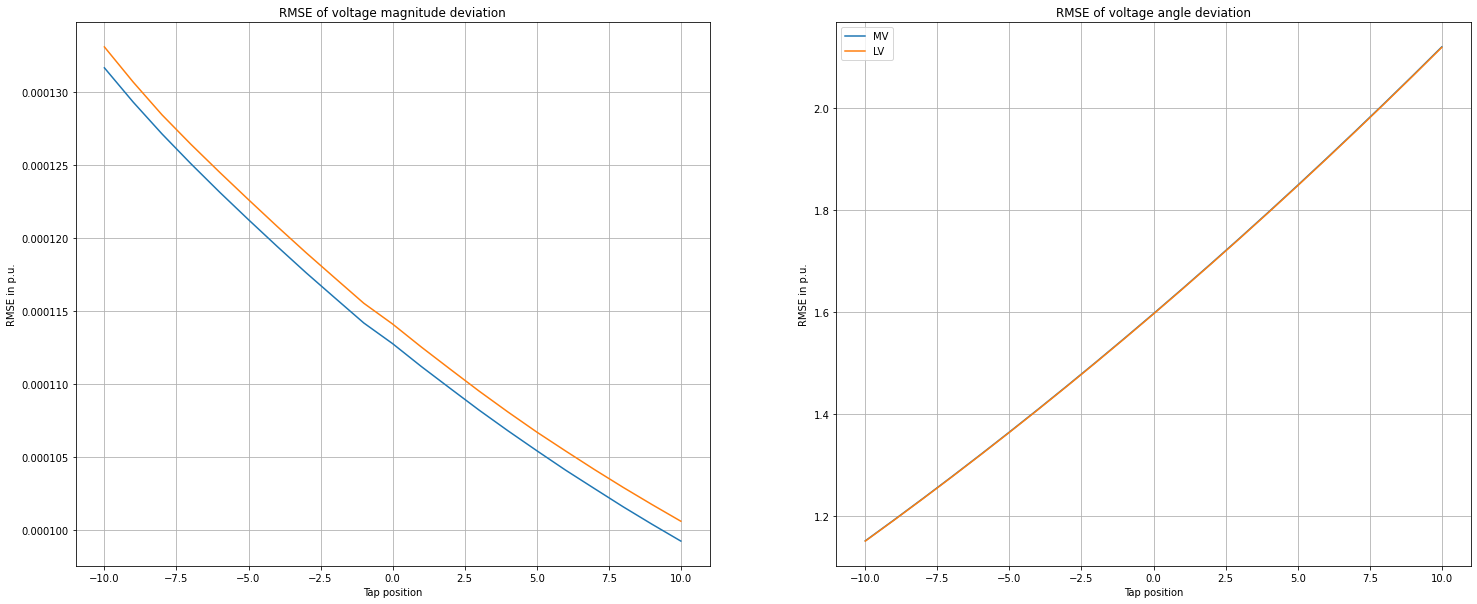

In [8]:
fig_delta_v_mv = plt.figure(figsize=(25, 10))

ax_delta_v_mv = fig_delta_v_mv.add_subplot(1, 2, 1)
ax_delta_v_mv.set_title('RMSE of voltage magnitude deviation')
ax_delta_v_mv.set_xlabel('Tap position')
ax_delta_v_mv.set_ylabel('RMSE in p.u.')
ax_delta_v_mv.grid()
tap_list = list(map(lambda x: x['tap'], tap_to_error))
delta_v_mv_rmse_list = list(map(lambda x: x['delta_v_mv_rmse'], tap_to_error))
delta_v_lv_rmse_list = list(map(lambda x: x['delta_v_lv_rmse'], tap_to_error))
ax_delta_v_mv.plot(np.array(tap_list), np.array(delta_v_mv_rmse_list))
ax_delta_v_mv.plot(np.array(tap_list), np.array(delta_v_lv_rmse_list))

ax_delta_v_ang_mv = fig_delta_v_mv.add_subplot(1, 2, 2)
ax_delta_v_ang_mv.set_title('RMSE of voltage angle deviation')
ax_delta_v_ang_mv.set_xlabel('Tap position')
ax_delta_v_ang_mv.set_ylabel('RMSE in p.u.')
ax_delta_v_ang_mv.grid()
delta_v_ang_mv_rmse_list = list(map(lambda x: x['delta_v_ang_mv_rmse'], tap_to_error))
delta_v_ang_lv_rmse_list = list(map(lambda x: x['delta_v_ang_lv_rmse'], tap_to_error))
ax_delta_v_ang_mv.plot(np.array(tap_list), np.array(delta_v_ang_mv_rmse_list), label="MV")
ax_delta_v_ang_mv.plot(np.array(tap_list), np.array(delta_v_ang_lv_rmse_list), label="LV")
ax_delta_v_ang_mv.legend()

## Visualize the power dependent error

Surface of power dependent error

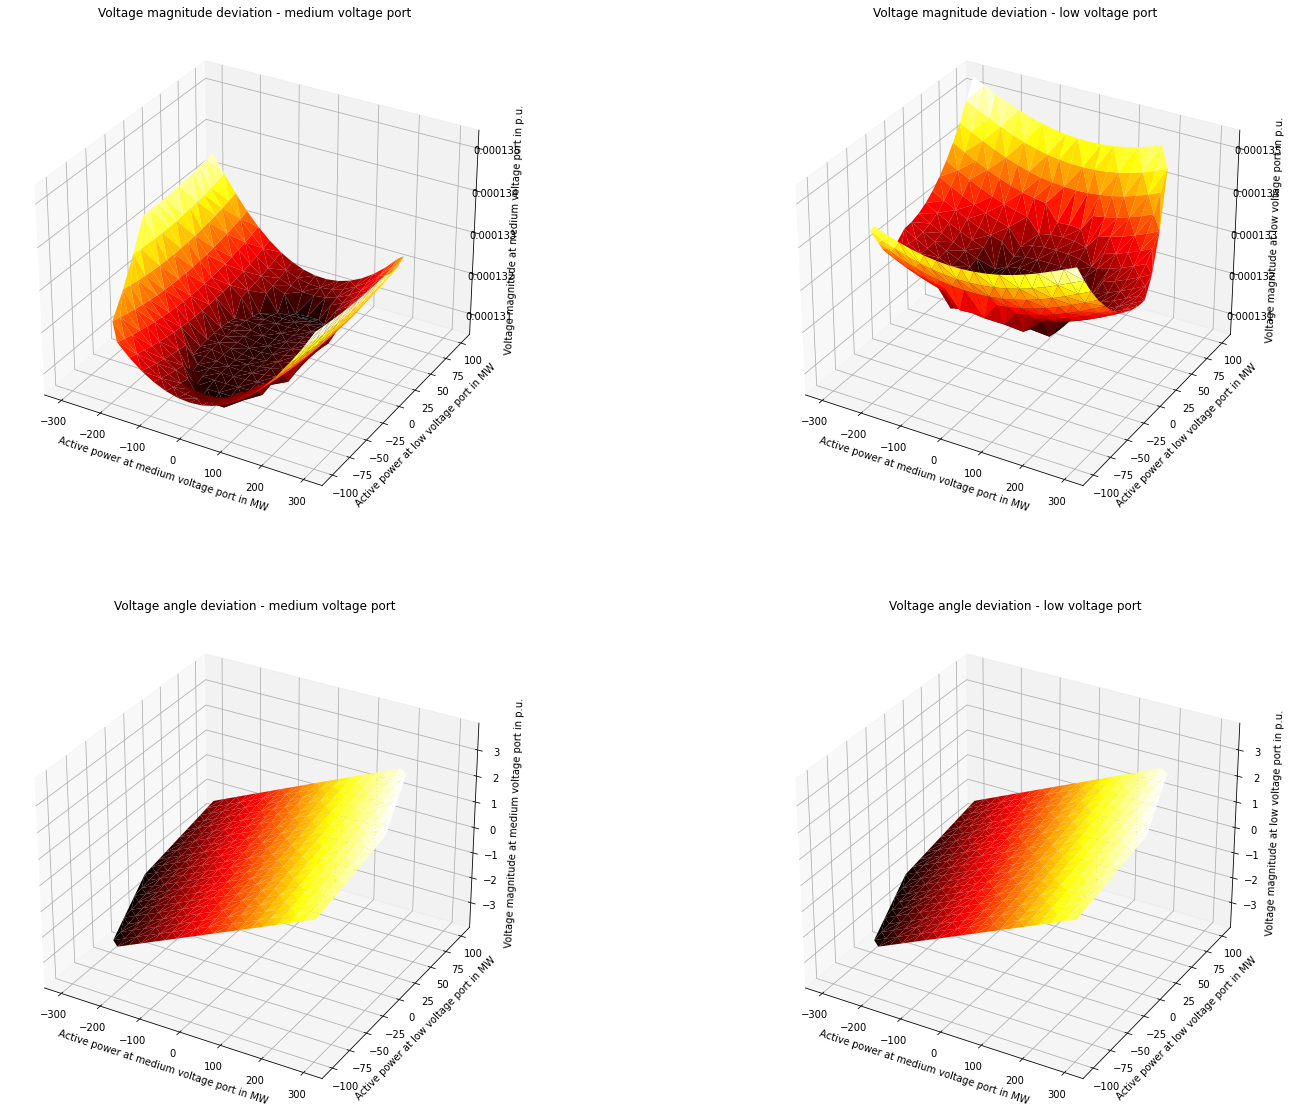

In [9]:
# --- Extract all information from results ---
p_mv_mw = []  # Power at medium voltage node
p_lv_mw = []  # Power at low voltage node
v_mv_pu = []  # Voltage magnitude at medium voltage port
v_ang_mv_degree = []  # Voltage angle at medium voltage port
v_lv_pu = []  # Voltage magnitude at low voltage port
v_ang_lv_degree = []  # Voltage angle at low voltage port
for result in tap_to_result[-10]:
    p_mv_mw.append(result['p_mv'])
    p_lv_mw.append(result['p_lv'])

    # Register nodal voltages and resulting joint power for all tap positions
    v_mv_pu.append(result['result'].v_mv_pu)
    v_ang_mv_degree.append(result['result'].v_ang_mv_degree)
    v_lv_pu.append(result['result'].v_lv_pu)
    v_ang_lv_degree.append(result['result'].v_ang_lv_degree)
for result in tap_to_result[10]:
    v_ang_mv_degree.append(result['result'].v_ang_mv_degree)
    v_ang_lv_degree.append(result['result'].v_ang_lv_degree)

v_min = min(v_mv_pu + v_lv_pu)
v_ang_min = min(v_ang_mv_degree + v_ang_lv_degree)
v_max = max(v_lv_pu + v_lv_pu)
v_ang_max = max(v_ang_mv_degree + v_ang_lv_degree)

fig_diff_p = plt.figure(figsize=(25, 20))
cmap_neutral_tap = plt.get_cmap('hot')
ax_neutral_tap_v_mv = fig_diff_p.add_subplot(2, 2, 1, projection='3d')
ax_neutral_tap_v_mv.set_title('Voltage magnitude deviation - medium voltage port')
ax_neutral_tap_v_mv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_mv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_mv.set_zlabel('Voltage magnitude at medium voltage port in p.u.')
ax_neutral_tap_v_mv.set_zlim(v_min, v_max)
ax_neutral_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_mv_pu), cmap=cmap_neutral_tap)

ax_neutral_tap_v_lv = fig_diff_p.add_subplot(2, 2, 2, projection='3d')
ax_neutral_tap_v_lv.set_title('Voltage magnitude deviation - low voltage port')
ax_neutral_tap_v_lv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_lv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_lv.set_zlabel('Voltage magnitude at low voltage port in p.u.')
ax_neutral_tap_v_lv.set_zlim(v_min, v_max)
ax_neutral_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_lv_pu), cmap=cmap_neutral_tap)

ax_neutral_tap_v_mv = fig_diff_p.add_subplot(2, 2, 3, projection='3d')
ax_neutral_tap_v_mv.set_title('Voltage angle deviation - medium voltage port')
ax_neutral_tap_v_mv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_mv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_mv.set_zlabel('Voltage magnitude at medium voltage port in p.u.')
ax_neutral_tap_v_mv.set_zlim(v_ang_min, v_ang_max)
ax_neutral_tap_v_mv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_ang_mv_degree), cmap=cmap_neutral_tap)

ax_neutral_tap_v_lv = fig_diff_p.add_subplot(2, 2, 4, projection='3d')
ax_neutral_tap_v_lv.set_title('Voltage angle deviation - low voltage port')
ax_neutral_tap_v_lv.set_xlabel('Active power at medium voltage port in MW')
ax_neutral_tap_v_lv.set_ylabel('Active power at low voltage port in MW')
ax_neutral_tap_v_lv.set_zlabel('Voltage magnitude at low voltage port in p.u.')
ax_neutral_tap_v_lv.set_zlim(v_ang_min, v_ang_max)
ax_neutral_tap_v_lv.plot_trisurf(np.array(p_mv_mw), np.array(p_lv_mw), np.array(v_ang_lv_degree), cmap=cmap_neutral_tap)